# PyTorch tutorial - Part3
Before we get into this tutorial, let us list out some bullet points from last tutorial.
- Computation of every Tensor is associated with a computation graph.
- If requires_grad attribute of a Tensor is True, 'backward' can be called on that Tensor which will compute gradient of that Tensor w.r.to the leaves in the computation graph of that Tensor. For getting the gradient of a Tensor w.r.to an internal node in the graph, we should call 'retain_grad' on the Tensor associated with the internal node prior to 'backward' call.  Of course, the requires_grad attributes of all those Tensors w.r.to which the gradients are to be computed must be set to True.
- The gradients are accumulated (not refreshed) into the 'grad' attribute of the Tensor.
- At the end of the 'backward' call, the computation graph associated with the Tensor on which 'backward' was called will be freed. A subequent call to 'backward' will fail. For this call to pass, the previous call should have been made with retain_graph argument set to true.
- Nodes of computation graph are 'Function' objects. We can get to know the 'Function' object through grad_fn attribute of the Tensor.
- 'backward' evaluates the graph backwards using chain rule. Internally, at each node,  it computes the product of transpose of Jacobian with the incoming gradient to obtain the gradient at that node.If the Tensor on which 'backward' is called is a multi-dimensional Tensor, the initial incoming gradients have to be supplied through the gradient argument in the 'backward' method.
- Hooks can be registered on a Tensor using 'register_hook' method. This hook will be called immediatedly after the gradients are computed w.r.to that Tensor during backpropagation. The hook takes the gradeint w.r.to that Tensor as input and either returns a new gradient or None. The current gradient cannot be modified by the hook. If new gradient is returned, it will be used further in the backpropgation. Otherwise the current gradient will be used.
- 'detach' method can be used to detach a Tensor from the computation graph. This method returns a new Tensor with its required_grad set to False but shares memory with the original Tensor.
-'grad' method in torch.autograd can be used for computing higher order derivatives.
- 'no_grad' context manager from torch.autograd can be used for running a set of computations that do not require 'backward'. The results of these computations are not buffered for backpropagation.
- If within the 'no_grad' context, requires_grad need to be enabled, 'enable_grad' context manager from torch.autograd can be used.

As a suggestion, it is better to avoid in-place operations in PyTorch. You can refer to [Inplace Semantics](https://pytorch.org/docs/stable/notes/autograd.html) for further details.


Also, I will list below few more utility methods defined in torch package that I request you to go through from [Pytorch Documentation](https://pytorch.org/docs/stable/torch.html). Many methods that we had already seen on Tensors are also defined through torch. Apart from that, I'm listing a few other methods from torch below:
- is_tensor, isnan, isfinite, isinf
- as_tensor
- arange
- cat
- stack
- save
- load
- max, min, argmax, argmin
- flatten
- meshgrid
- matmul



Having got familiarity with Tensors and Autograd mechanics in Pytorch, we will start building neural networks in this tutorial. The primary class defined in PyTorch for this purpose is the 'Module' class in torch.nn. This should form the base class for all the models we are going to build in Pytorch. We will understand the 'Module class in detail through various examples.
<br>
<br>
To start with let's code the model described in exercise 2 in assignment 2c. The model is as follows:

I/p---->Linear1---->ReLU----->Linear2---->ReLU---->Linear3----ReLU---->Linear4---->ReLU--->Linear5---->Sigmoid      
    where: 
    
       Linear1 has 64*64*3=12288 incoming connections and 30 outgoing connections
       Linear2 has 30 incoming connections and 30 outgoing connections
       Linear3 has 30 incoming  connections and 30 outgoing connections 
       Linear4 has 30 incoming  connections and 30 outgoing connections
       Linear5 has 30 incoming  connections and 1 outgoing connection


In [0]:
import torch
import torch.nn as nn
class MyModel(nn.Module): # your model is inheriting from the base class
    def __init__(self, infeatures): # infeatures is the size of input features
                                              # nclasses is the number of classes
        super().__init__()
        self.infeatures = infeatures
        
        self.fc1 = nn.Linear(self.infeatures, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, 30)
        self.fc5 = nn.Linear(30, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x): # forward method of base class 'Module' overridden here
                          # size of x is (batch_size, infeatures)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x # size of x here is (batch_size, 1)

That's it. The model is ready. Let us understand the above code carefully.
- First, your model has to inherit from 'Module' class. This class is a container that contains your model. It has lot of useful methods that your model can use. We will see those methods and learn how to use them as we go along.
- The  \_\_init\_\_ method performs initialization of your model. First, you invoke base class initialization. The number of input features is initialized by passing it as argument during initialization.
- This model is made up of fully connected layers. We can create them using the 'Linear' class in torch.nn. This class itself is a subclass of 'Module' class. An object of this class can be instantiated by supplying the infeatures and outfeatures parameter. Once the object is instantiated, a weight Tensor of size (outfeatures, infeatures)  is automatically created and initialized with values in uniform($-\sqrt{k}, \sqrt{k}$) where $k$ = $\frac{1}{infeatures}$. 
- If bias parameter during instantiation of 'Linear' Module is set to True, a bias Tensor also is automatically created and initialized to random values. 
- Both  weight Tensor and bias Tensor are objects of type 'Parameter' defined in torch.nn. 'Parameter' is a subclass of Tensor. A 'Parameter' object is a special Tensor object because it has by default requires_grad set to True and so is learnable. So, weight and bias Parameters associated with the 'Linear' Module are learnable.
- Non-linear activations like ReLU and Sigmoid are also modeled as subclasses of 'Module'. They can be instantiated as shown in the above code. They do not have any 'Parameter's associated with them. Their 'forward' method will apply the required non-linearity.
- Your model must override the 'forward' method in the base 'Module' class. This method can take any number of parameters. In this example it takes the input x. 
- Note that x has to be of size (batch_size, infeatures) for it to be an input to 'Linear' Module. In fact, PyTorch 'Module's operate on input that come in batches. batch_size is generally the first dimension for most 'Module's but in some cases like RNN's and its variants, we can set batch_size to be second dimension if we want to. 
- In PyTorch, 'Module's are callable classes where the 'forward' method of the Module is called. Therefore, when we call self.fc1(x) in the forward method above, we are actually calling self.fc1.forward(x). Similar is the case with other calls in the forward method defined above. Implicit calling of forward is preferred since this has the special effect of making sure the registered_hooks on the 'Module's are called. Explicit calling of forward ignores the hooks.
<br>
<br>
The code below will add more clarity w.r.to the 'Parameter's associated with 'Linear' Module's.

In [2]:
mymodel = MyModel(12288)
print('mymodel:\n\n')
for i, (name, m) in enumerate(mymodel.named_children()): # since mymodel is inherited from 'Module', 'named_children' method can be used on it to get an iterator 
                                                         # over its immediate children, yielding both the name of the module as well as the module itself.
                                                         #If you do not want name, you can use 'children' method in the 'Module' class
  print(f'\t\tSubmodule {i}:\n\t\t\tName:\t{name}')
  if type(m) == nn.Linear: # the attributes weight and bias are available only for Linear modules in this model
    print(f'\t\t\tweight.size:\t{m.weight.size()}\n\t\t\tweight.requires_grad:\t{m.weight.requires_grad}\n\t\t\tbias.size: \
            \t{m.bias.size()}\n\t\t\tbias.requires_grad:\t{m.bias.requires_grad}\n')



mymodel:


		Submodule 0:
			Name:	fc1
			weight.size:	torch.Size([30, 12288])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 1:
			Name:	fc2
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 2:
			Name:	fc3
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 3:
			Name:	fc4
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 4:
			Name:	fc5
			weight.size:	torch.Size([1, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([1])
			bias.requires_grad:	True

		Submodule 5:
			Name:	relu
		Submodule 6:
			Name:	sigmoid


Suppose you want to initialize biases to zero and weights to be sampled from standard normal multiplied by 0.01. We can use the 'apply' method of 'Module' class as follows.

In [3]:
def init_params(m):
  if type(m) == nn.Linear:
    m.weight.data = torch.randn(m.weight.size())*.01
    m.bias.data = torch.zeros(m.bias.size())

mymodel.apply(init_params) # applies init_params function to each immediate child Module and itself
# we will verify by print bias Parameter of all Linear layers
for i, m in enumerate(mymodel.children()):
  if type(m) == nn.Linear:
    print(f'Bias Parameter of fc{i}:\t{m.bias.data}')

Bias Parameter of fc0:	tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
Bias Parameter of fc1:	tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
Bias Parameter of fc2:	tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
Bias Parameter of fc3:	tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
Bias Parameter of fc4:	tensor([0.])


We can also build the same model using another container class in torch.nn namely 'Sequential'.  Modules will be added to it in the sequential order they are passed in the constructor. note that 'Sequential' is inherited from 'Module'. So, all the methods defined in 'Module'  can be used on 'Sequential' objects as well. See the example below.

In [4]:
mymodel_1 = nn.Sequential(
                          nn.Linear(12288, 30),
                          nn.ReLU(),
                          nn.Linear(30, 30),
                          nn.ReLU(),
                          nn.Linear(30, 30),
                          nn.ReLU(),
                          nn.Linear(30, 30),
                          nn.ReLU(),
                          nn.Linear(30, 1),
                          nn.Sigmoid()
                        )
for i, (name, m) in enumerate(mymodel_1.named_children()):
    print(f'\t\tSubmodule {i}:\n\t\t\tName:\t{name}')
    if type(m) == nn.Linear: # the attributes weight and bias are available only for Linear modules in this model
        print(f'\t\t\tweight.size:\t{m.weight.size()}\n\t\t\tweight.requires_grad:\t{m.weight.requires_grad}\n\t\t\tbias.size: \
            \t{m.bias.size()}\n\t\t\tbias.requires_grad:\t{m.bias.requires_grad}\n')    

		Submodule 0:
			Name:	0
			weight.size:	torch.Size([30, 12288])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 1:
			Name:	1
		Submodule 2:
			Name:	2
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 3:
			Name:	3
		Submodule 4:
			Name:	4
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 5:
			Name:	5
		Submodule 6:
			Name:	6
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 7:
			Name:	7
		Submodule 8:
			Name:	8
			weight.size:	torch.Size([1, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([1])
			bias.requires_grad:	True

		Submodule 9:
			Name:	9


Carefully observe how the naming of submodules is done. It is the range of numbers from 0 to 9 in the order submodules were passed to 'Sequential' constructor. If you want to explicitly provide names to the submodules as you had done earlier, you can pass them as ordered dict as shown in the following example.

In [5]:
from collections import OrderedDict
mymodel_1 = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(12288, 30)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(30, 30)),
                            ('relu2', nn.ReLU()),
                            ('fc3', nn.Linear(30, 30)),
                            ('relu3', nn.ReLU()),
                            ('fc4', nn.Linear(30, 30)),
                            ('relu4',nn.ReLU()),
                            ('fc5', nn.Linear(30, 1)),
                            ('sigmoid', nn.Sigmoid())
                          ])
                        )
for i, (name, m) in enumerate(mymodel_1.named_children()):
    print(f'\t\tSubmodule {i}:\n\t\t\tName:\t{name}')
    if type(m) == nn.Linear: # the attributes weight and bias are available only for Linear modules in this model
        print(f'\t\t\tweight.size:\t{m.weight.size()}\n\t\t\tweight.requires_grad:\t{m.weight.requires_grad}\n\t\t\tbias.size: \
            \t{m.bias.size()}\n\t\t\tbias.requires_grad:\t{m.bias.requires_grad}\n')    

		Submodule 0:
			Name:	fc1
			weight.size:	torch.Size([30, 12288])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 1:
			Name:	relu1
		Submodule 2:
			Name:	fc2
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 3:
			Name:	relu2
		Submodule 4:
			Name:	fc3
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 5:
			Name:	relu3
		Submodule 6:
			Name:	fc4
			weight.size:	torch.Size([30, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([30])
			bias.requires_grad:	True

		Submodule 7:
			Name:	relu4
		Submodule 8:
			Name:	fc5
			weight.size:	torch.Size([1, 30])
			weight.requires_grad:	True
			bias.size:             	torch.Size([1])
			bias.requires_grad:	True

		Submodule 9:
			Name:	sigmoid


Another observation is that we have not explicitly overridden 'forward' method in this case. When we call, for example, mymodel_1(x), since it is a 'Sequential' object, the 'forward' method of each of the submodule contained in mymodel_1 is called in order with each 'forward' taking as input the result of the previous 'forward'. The result of final 'forward' is returned.

Having defined the model, let us now focus on data. Make sure you have uploaded the datasets folder you have been using in assignments 1 and 2 to your google drive. Then run the following cell and complete the authorisation.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Now check if the datasets folder is available as shown below.

In [7]:
ls /content/drive/My\ Drive/datasets/

test_catvnoncat.h5  train_catvnoncat.h5


The following code opens the train data h5 file and prints some of its properties.

In [8]:
import h5py
import os
import numpy as np
data_path = '/content/drive/My Drive/datasets'
train_data = h5py.File(os.path.join(data_path, 'train_catvnoncat.h5'), "r")
print(f'Keys in train_data dictionary:\n{[key for key in train_data.keys()]}')
print(f'Number of images in the training set:\n{train_data["train_set_x"].shape[0]}')
print(f'Shape of the training_set of images:\n{train_data["train_set_x"].shape}')
print(f'Shape of the training_set of labels:\n{train_data["train_set_y"].shape}')

train_x = np.array(train_data["train_set_x"], dtype=np.uint8)
train_x = train_x / 255.
avg = np.mean(train_x, axis = (0, 1, 2))
std = np.std(train_x, axis = (0, 1, 2))
print(f'Mean of scaled (by 255) training set across RGB cahnnels: {avg}')
print(f'Standard deviation of scaled (by 255) training set across RGB cahnnels: {std}')

Keys in train_data dictionary:
['list_classes', 'train_set_x', 'train_set_y']
Number of images in the training set:
209
Shape of the training_set of images:
(209, 64, 64, 3)
Shape of the training_set of labels:
(209,)
Mean of scaled (by 255) training set across RGB cahnnels: [0.43553055 0.42217036 0.35414762]
Standard deviation of scaled (by 255) training set across RGB cahnnels: [0.26568017 0.24862071 0.26769836]


In PyTorch a dataset is represented by an abstract class named 'Dataset' defined in torch.utils.data. All other datasets should subclass it. All subclasses should override ''\_\_len\_\_' method that returns the size of the dataset, and '\_\_getitem\_\_' method that returns the i$^{th}$ data item where i varies from 0 to size of the dataset minus 1. So, a data in the dataset comes out through the  '\_\_getitem\_\_' method. Note that, in python,  '\_\_getitem\_\_' method defined in a class enables its object to be indexed by an index i and, it returns the i$^{th}$ item of the object. Item in our example means the image and the corresponding label.

In [0]:
from torch.utils.data import Dataset

class CatDataset(Dataset):
    
    def __init__(self, data_path = '/content/drive/My Drive/datasets/train_catvnoncat.h5', transform = None):
        self.transform = transform
        self.data = h5py.File(data_path, 'r')
        keys = [key for key in self.data.keys()]
        for i in range(len(keys)):
            if 'set_x' in keys[i]:
                self.images = np.array(self.data[keys[i]][:], dtype=np.uint8)
            elif 'set_y' in keys[i]:
                self.labels = np.array(self.data[keys[i]][:], dtype=np.int)
                
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, i):
        assert 0<=i<len(self), f'i={i} corresponding to item number {i+1} exceeds size of the dataset that is {self.__len__()}'
        image = self.images[i]
        label = self.labels[i]
        if self.transform:
            image = self.transform(image)
        else:
            image = image.transpose(2, 0, 1)
            image = image/255.
            image = torch.from_numpy(image)
            image = image.to(dtype=torch.float32)
        
        label = torch.tensor(label, dtype=torch.uint8)
        return image, label
        
    

Let us understand the 'CatDataset' class.

*   First, it inherits from 'Dataset' class. 'Dataset' is an abstract class that does not do any initialization. So, we don't call super().\_\_init\_\_().
*   In its initialization, it opens the h5 file from the given path to the data. The path could point to train data or test data. We subsequently read all the images and the labels  as numpy arrays. We read the images as uint8 arrays as this will be required by certain methods from torchvision package that we will discuss later.
* Our 'CatDataset' class should override '\_\_len\_\_' method. Here it returns the length of the dataset.
* Our 'CatDataset' class should override '\_\_getitem\_\_' method. Here it returns the i$^{th}$ image and its corresponding label. i is input parameter to '\_\_getitem\_\_' method. Before returning the image and the label, the transforms are applied if they had been supplied during initialization. We assume that if self.transform is not None, then there is a transform that converts the image to a Tensor in the range [0, 1] before return. We will see about this a little later. If self.transfrom is None, we explicitly convert the image to a Tensor  in the range [0, 1]. Note that Pytorch requires the channels x height x width format unlike numpy that works with height x width x channels format. So we need to permute the dimensions. Label also is converted to a Tensor before return.
* In this definition of 'CatDataset' class, during intiialization we have read all the images and labels into CPU memory. This is fine because the dataset is small (only 209 images each 64x64x3 in size of uint8 dtype totally requiring around only 2.6MB). Otherwise, we can read the image directly in the '\_\_getitem\_\_' method as shown below.



In [0]:
class CatDataset_eff(Dataset):
    
    def __init__(self, data_path = '/content/drive/My Drive/datasets/train_catvnoncat.h5', transform = None):
        self.transform = transform
        self.data = h5py.File(data_path, 'r')
        keys = [key for key in self.data.keys()]
        for i in range(len(keys)):
            if 'set_x' in keys[i]:
                self.image_key = keys[i]
            elif 'set_y' in keys[i]:
                self.label_key = keys[i]
                
    def __len__(self):
        return 209 if 'train' in self.image_key else 50
    
    def __getitem__(self, i):
        assert 0<=i<len(self), f'i={i} corresponding to item number {i+1} exceeds size of the dataset that is {self.__len__()}'
        image = np.array(self.data[self.image_key][i], dtype=np.uint8)
        label = self.data[self.label_key][i]
        if self.transform:
            image = self.transform(image)
        else:
            image = image.transpose(2, 0, 1)
            image = image/255.
            image = torch.from_numpy(image)
            image = image.to(dtype=torch.float)
        
        label = torch.tensor(label, dtype=torch.uint8)
        return image, label

In [11]:
from torch.utils.data import DataLoader
dset = CatDataset_eff()
loader = DataLoader(dset, batch_size=64, shuffle=False, num_workers=2)
for x, y in loader:
    print(y)

tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=torch.uint8)
tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], dtype=torch.uint8)
tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)


Let's instantiate both the Dataset classes and extract some images and their labels.

In [12]:
data_path = '/content/drive/My Drive/datasets/train_catvnoncat.h5'
dset = CatDataset()

image, label = dset[5]
print(f'Image {5} with size {image.size()} and label {label}')

image, label = dset[11]
print(f'Image {11} with size {image.size()} and label {label}')

image, label = dset[203]
print(f'Image {203} with size {image.size()} and label {label}')

image, label = dset[209]
print(f'Image {209} with size {image.size()} and label {label}')


Image 5 with size torch.Size([3, 64, 64]) and label 0
Image 11 with size torch.Size([3, 64, 64]) and label 1
Image 203 with size torch.Size([3, 64, 64]) and label 0


AssertionError: ignored

In [13]:
data_path = '/content/drive/My Drive/datasets/test_catvnoncat.h5'
dset = CatDataset_eff(data_path = data_path)

image, label = dset[5]
print(f'Image {5} with size {image.size()} and label {label}')

image, label = dset[11]
print(f'Image {11} with size {image.size()} and label {label}')

image, label = dset[203]
print(f'Image {203} with size {image.size()} and label {label}')

Image 5 with size torch.Size([3, 64, 64]) and label 0
Image 11 with size torch.Size([3, 64, 64]) and label 1


AssertionError: ignored

Now let's look at transforms. Transforms are useful when we want to augument data, normalize data and convert data to Pytorch Tensor. For applying transforms to images, Pytorch requires them to be PIL images. Let us consider applying RandomHorizontalFlip to our data. Further we also want to convert the PIL image/nd array to Tensor and normalize. See the example below.

In [0]:
import torchvision.transforms

transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToPILImage(),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=(0.43553055, 0.42217036, 0.35414762), std=(0.26568017, 0.24862071, 0.26769836))                                           
                                           ])

'Compose' is a callable class that when called applies the given sequence of transforms in order. In th example above, we wanted to apply 'RandomHorizontalFlip'. But prior to that, the ndarray need to be transformed to PIL image. So we require 'ToPILImage' transform. After 'RandomHorizontalFlip', we have to transform back the PIL image to Tensor. So, we require 'ToTensor' transform. Finally we normalize the Tensor using 'Normalize' transform. You must look into the documentation of these transforms to understand their behaviour.

We will now again instantiate our dataset classes with these tranforms and display some images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


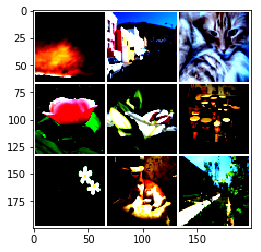

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
dset = CatDataset(transform = transforms)
grid_tensor = torch.empty((9, 3, 64, 64))
for i in range(0, 9):
    grid_tensor[i] = dset[i][0]

grid_tensor = torchvision.utils.make_grid(grid_tensor, nrow=3, padding=2, pad_value=1) # very useful method to make a grid of images and display them
show(grid_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


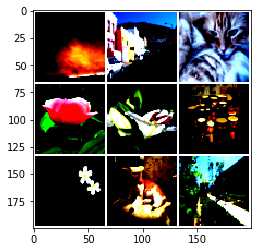

In [16]:
dset = CatDataset_eff(transform = transforms)
grid_tensor = torch.empty((9, 3, 64, 64))
for i in range(0, 9):
    grid_tensor[i] = dset[i][0]

grid_tensor = torchvision.utils.make_grid(grid_tensor, nrow=3, padding=2, pad_value=1)
show(grid_tensor)

So, you must have got an idea about 'Dataset' class. There are more available in torch.utils.data. To summarise,  your dataset class should inherit from 'Dataset' class and, override ''\_\_len\_\_' and '\_\_getitem\_\_' methods. \_\_getitem\_\_' method must return the i$^{th}$ item of the dataset.
<br>
<br>
Now, from this 'Dataset' class we should be able to extract minibatch of images and labels during training. We can explicitly do that in a loop. But if we want to use a particular strategy for sampling and/or shuffle the data and/or use multiple threads to load the minibatch etc, it becomes difficult for us to write the code that handles all these scenarios. Instead we can use the 'DataLoader' class available in torch.utils.data. It combines a dataset and a sampler, and provides an iterable. 
<br>
<br>
Let us see an example.

In [0]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dset, batch_size=64, shuffle=True, num_workers=4)

We have instantiated a 'DataLoader' over the 'CatDataset_eff' object dset asking it to load  minibatch of images and labels from dset of size 32 with data shuffled. We want 4 threads/processes to participate in this process thereby making the loading process faster. The 'DataLoader' object can be made as an iterator object that we can use to iterate over dset to get minibatches with data shuffled across minibatches. See the code below.

In [18]:
train_loader_iter = iter(train_loader)
images, labels=next(train_loader_iter)
print(f'Minibatch 1 size: {images.size(0)}')
print(f'Size of images Tensor:{images.size()}')
print(f'Size of labels Tensor:{labels.size()}\n')
images, labels=next(train_loader_iter)
print(f'Minibatch 2 size: {images.size(0)}')
print(f'Size of images Tensor:{images.size()}')
print(f'Size of labels Tensor:{labels.size()}\n')
images, labels=next(train_loader_iter)
print(f'Minibatch 3 size: {images.size(0)}')
print(f'Size of images Tensor:{images.size()}')
print(f'Size of labels Tensor:{labels.size()}\n')
images, labels=next(train_loader_iter)
print(f'Minibatch 4 size: {images.size(0)}')
print(f'Size of images Tensor:{images.size()}')
print(f'Size of labels Tensor:{labels.size()}\n')

Minibatch 1 size: 64
Size of images Tensor:torch.Size([64, 3, 64, 64])
Size of labels Tensor:torch.Size([64])

Minibatch 2 size: 64
Size of images Tensor:torch.Size([64, 3, 64, 64])
Size of labels Tensor:torch.Size([64])

Minibatch 3 size: 64
Size of images Tensor:torch.Size([64, 3, 64, 64])
Size of labels Tensor:torch.Size([64])

Minibatch 4 size: 17
Size of images Tensor:torch.Size([17, 3, 64, 64])
Size of labels Tensor:torch.Size([17])



We can see that the last minibatch has size 17 since 209 is not exactly divisible by 64. Now the dset has been exhausted and therefore one more 'next' call will give an error. If you want to iterate through the dset again, you have to create the iterator again.

In [19]:
next(train_loader_iter)

StopIteration: ignored

We are now ready to train our model. See the code below.

In [20]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms
from torch.utils.data import DataLoader

def train(model, loader, loss_criterion, optimizer, num_epochs):
  for epoch in range(num_epochs): # for each epoch
    for images, labels in loader: # for each batch of images and labels
      if torch.cuda.is_available(): # if gpu available,
        images = images.to(device = 'cuda') 
        labels = labels.to(device = 'cuda') # move batch of images and labels to gpu memory
      images = flatten(images) # flatten the batch of images since our model is fully connected
      outputs = model(images) # do forward propagation
      loss = loss_criterion(outputs.squeeze(), labels.to(dtype = torch.float)) # compute loss
      optimizer.zero_grad() # make sure gradients of parameters are zeroed before backpropagation to avoid accumulation
      loss.backward() # do the backpropagation
      optimizer.step() # update the parameters
      
    if epoch%100 == 0:
      print(f'Training loss at epoch {epoch+1}:\t{loss.item()}')
  return mymodel    
def flatten(z):
    m, c, h, w= z.shape
    nx = h*w*c
    z = z.reshape((m, nx))
    return z 
      
def main():
  mymodel = MyModel(12288) # instantiate the model
  mymodel.apply(init_params) # initialize parameters
  if torch.cuda.is_available():
    mymodel = mymodel.to(device = 'cuda') # move entire model to gpu memory; all its parameters, buffers are moved to gpu memory
  loss_criterion = nn.BCELoss() # instantiate the loss criterion; since we are doing binary classification, we will use binary cross entropy loss
  optimizer = optim.SGD(mymodel.parameters(), lr=0.0015) # instantiate optimizer; here we are using stochastic gradient descent 
                                                                  # with learning rate as 0.008 
    
  # next few lines will build the loader to load the data
  ########################################################################
  transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToPILImage(),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=(0.43553055, 0.42217036, 0.35414762), std=(0.26568017, 0.24862071, 0.26769836))                                           
                                           ])
  dset = CatDataset()
  train_loader = DataLoader(dset, batch_size=64, shuffle=True, num_workers=4)
  ########################################################################
  
  return train(mymodel, train_loader, loss_criterion, optimizer, 500)

if __name__ == '__main__':
  mymodel = main()

Training loss at epoch 1:	0.6930069327354431
Training loss at epoch 101:	0.6863360404968262
Training loss at epoch 201:	0.7011944055557251
Training loss at epoch 301:	0.6795673966407776
Training loss at epoch 401:	0.644843578338623


We had not dicussed about loss criterion and optimizer. You can refer to torch.nn module for a variety of loss functions. For optimizers, PyTorch has a small package called torch.optim. It contains a variety of optimizers. You can have a look at them. Two important points are: (i) We should make sure before calling 'backward' method on the loss Tensor, the gradients are zeroed out. For this we can use 'zero_grad' method on the optimizer object. Note that while initializing optimizer, we send it all the learnable parameters by calling 'parameters' method on the module. (ii) parameter updates happen by calling 'step' method on the optimizer object. Optimizer object has access to all the learnable parameters and so it does the update when 'step'  is called. Also note that we have used 'item' method on loss Tensor while printing since we require here only the scalar value of the loss Tensor and not the entire Tensor.



 

## Assignment
1. Write code to test the model and print the accuracy.
2. Use Xavier initialization on all weight parameters of your model and report the history of training loss, and test accuracy. For this torch.nn.init will be very useful.
3. Modify your data set class so that it can return train data or validation data based on its 'sampler' keyword argument. The method 'SubsetRandomSampler' in torch.utils.data will be useful.

In [21]:
# 1. Write code to test the model and print the accuracy.

# Answer 1:


dset_test = CatDataset_eff(data_path='/content/drive/My Drive/datasets/test_catvnoncat.h5')
test_loader = DataLoader(dset_test, batch_size=16, num_workers=4)

def predict(outputs):
    return outputs > 0.5

def test(model, loader, loss_criterion):
    loss = 0
    acc = 0.
    for images, labels in loader:
        if torch.cuda.is_available():
            images = images.to(device='cuda')
            labels = labels.to(device='cuda')
        images = flatten(images)
        outputs = model(images)
        # print(outputs)
        loss += loss_criterion(outputs.squeeze(), labels.to(dtype=torch.float))
        acc += np.sum(predict(outputs.squeeze().detach().cpu().numpy()) == labels.to(dtype=torch.float).cpu().numpy())
    print("Loss: \t\t", loss.item()/len(loader.dataset),"\nAccuracy: \t", float(acc)/len(loader.dataset))

if torch.cuda.is_available():
    mymodel = mymodel.to(device='cuda')
test(mymodel, test_loader, loss_criterion=nn.BCELoss())
    

Loss: 		 0.05545173645019531 
Accuracy: 	 0.68


In [22]:
# 2. Use Xavier initialization on all weight parameters of your model and report the history of training loss, and test accuracy.
#    For this torch.nn.init will be very useful.mymodel = MyModel(12288)

# Answer: 

def init_params(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        m.bias.data = torch.zeros(m.bias.size())

transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToPILImage(),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=(0.43553055, 0.42217036, 0.35414762), std=(0.26568017, 0.24862071, 0.26769836))                                           
                                           ])
dset = CatDataset()
train_loader = DataLoader(dset, batch_size=64, shuffle=True, num_workers=4)

mymodel = MyModel(12288)
mymodel.apply(init_params)
if torch.cuda.is_available():
    mymodel = mymodel.to(device='cuda')
loss_criterion = nn.BCELoss()
optimizer = optim.SGD(mymodel.parameters(), lr=0.001)
mymodel = train(mymodel, train_loader, loss_criterion, optimizer, 500)
test(mymodel, test_loader, loss_criterion)    


Training loss at epoch 1:	0.6844162940979004
Training loss at epoch 101:	0.5793744921684265
Training loss at epoch 201:	0.5593104958534241
Training loss at epoch 301:	0.5890556573867798
Training loss at epoch 401:	0.31251296401023865
Loss: 		 0.059546289443969724 
Accuracy: 	 0.7


In [0]:
# 3. Modify your data set class so that it can return train data or validation data based on its 'sampler' keyword argument.
#    The method 'SubsetRandomSampler' in torch.utils.data will be useful.

# Answer 3: By modifiing the CatDataset class:-


valid_size = 0.2
num_train = len(dset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]

class CatDataset_modified(Dataset):
    
    def __init__(self, indices, data_path = '/content/drive/My Drive/datasets/train_catvnoncat.h5', transform = None):
        self.transform = transform
        self.data = h5py.File(data_path, 'r')
        keys = [key for key in self.data.keys()]
        for i in range(len(keys)):
            if 'set_x' in keys[i]:
                self.images = np.array(self.data[keys[i]][:], dtype=np.uint8).take(indices)
            elif 'set_y' in keys[i]:
                self.labels = np.array(self.data[keys[i]][:], dtype=np.int).take(indices)
                
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, i):
        assert 0<=i<len(self), f'i={i} corresponding to item number {i+1} exceeds size of the dataset that is {self.__len__()}'
        image = self.images[i]
        label = self.labels[i]
        if self.transform:
            image = self.transform(image)
        else:
            image = image.transpose(2, 0, 1)
            image = image/255.
            image = torch.from_numpy(image)
            image = image.to(dtype=torch.float32)
        
        label = torch.tensor(label, dtype=torch.uint8)
        return image, label

train_dset = CatDataset_modified(train_indices)
valid_dset  = CatDataset_modified(valid_indices)

train_loader = DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=4)
valid_loader  = DataLoader(valid_dset, batch_size=32, shuffle=True, num_workers=4)


In [0]:
# Answer 3: By using SubsetSampler method in DataLoader:-

valid_size = 0.2
num_train = len(dset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_indices)

train_loader = torch.utils.data.DataLoader(
        dset,
        batch_size=32,
        sampler=train_sampler,
        num_workers=4
        )

valid_loader = torch.utils.data.DataLoader(
        dset, 
        batch_size=32,
        sampler=valid_sampler,
        num_workers=4
        )

def train_valid(model, dset, valid_size, loss_criterion=nn.BCELoss(), optimizer=optim.SGD(mymodel.parameters(), lr=0.0015), num_epochs=500, batch_size=32):
  for epoch in range(num_epochs): # for each epoch
    valid_size = 0.2
    num_train = len(dset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_indices, valid_indices = indices[split:], indices[:split]
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_indices)
    train_loader = torch.utils.data.DataLoader(
            dset,
            batch_size=32,
            sampler=train_sampler,
            num_workers=4
            )

    valid_loader = torch.utils.data.DataLoader(
            dset, 
            batch_size=32,
            sampler=valid_sampler,
            num_workers=4
            )
    for images, labels in train_loader: # for each batch of images and labels
      if torch.cuda.is_available(): # if gpu available,
        images = images.to(device = 'cuda') 
        labels = labels.to(device = 'cuda') # move batch of images and labels to gpu memory
      images = flatten(images) # flatten the batch of images since our model is fully connected
      outputs = model(images) # do forward propagation
      loss = loss_criterion(outputs.squeeze(), labels.to(dtype = torch.float)) # compute loss
      optimizer.zero_grad() # make sure gradients of parameters are zeroed before backpropagation to avoid accumulation
      loss.backward() # do the backpropagation
      optimizer.step() # update the parameters
      
    if epoch%100 == 0:
      print(f'Training loss at epoch {epoch+1}:\t{loss.item()}')
      print("Validation Loss and Accuracy:")
      test(model, test_loader, loss_criterion)
  return mymodel    


In [26]:
mymodel = MyModel(12288)
mymodel.apply(init_params)
if torch.cuda.is_available():
  mymodel = mymodel.to(device = 'cuda')

mymodel = train_valid(model=mymodel, dset=dset, valid_size=0.2)
  

Training loss at epoch 1:	0.6940304636955261
Validation Loss and Accuracy:
Loss: 		 0.055101776123046876 
Accuracy: 	 0.56
Training loss at epoch 101:	0.7121949195861816
Validation Loss and Accuracy:
Loss: 		 0.05531870365142822 
Accuracy: 	 0.52
Training loss at epoch 201:	0.6986722946166992
Validation Loss and Accuracy:
Loss: 		 0.054822778701782225 
Accuracy: 	 0.6
Training loss at epoch 301:	0.6637008786201477
Validation Loss and Accuracy:
Loss: 		 0.03755764961242676 
Accuracy: 	 0.54
Training loss at epoch 401:	0.7136144042015076
Validation Loss and Accuracy:
Loss: 		 0.048306818008422854 
Accuracy: 	 0.46
